# Finding Similar Neighborhoods in Dallas and Houston  
----------
In this notebook, we will walk through the complete process of building an app that will find similar neighborhoods between Dallas and Houston using the *kmeans* algorithm.  For a detailed summary of this analysis, please refer to the [report](./report.ipynb) in this repository. To try out the application, go to https://dfw-houston-clustering.herokuapp.com/

# Table of Contents
---------------------

1. [Zip Codes](#zipcodes)
2. [Demographics](#demographics)
3. [Foursquare Data](#foursquare)
4. [KMeans Clustering Model](#kmeans)
5. [Folium Maps](#folium)
6. [Streamlit](#streamlit)
7. [Heroku](#heroku)
8. [Application](#application)

<a id ='zipcodes'></a>
### Zip Codes
-----------

Let's first start with getting the zip codes for the Greater Houston and Dallas-Fort Worth areas as well as naming our zip codes.


In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Load initial zip code data into pandas dataframes
dfw_zipcodes = pd.read_csv('./Data/DFW_zip_codes.csv', header = None, names = ['Zip_Code'])
houston_zipcodes = pd.read_csv('./Data/Greater_Houston_zip_codes.csv', header = None, names = ['Zip_Code'])

In [3]:
# Examine what our data looks like
dfw_zipcodes.head()

,Zip_Code
0,75001 (Addison)
1,75002 (Allen)
2,75006 (Carrollton)
3,75007 (Carrollton)
4,75009 (Celina)


In [4]:
houston_zipcodes.head()

,Zip_Code
0,77002 (Houston)
1,77003 (Houston)
2,77004 (Houston)
3,77005 (West University Place)
4,77006 (Houston)


We need to split the zip code column into 2 columns.  One for the zip codes and the other for the names of the zip codes.  Additionally, we need to remove the parentheses. Let's make a simple function to do all of this for us.

In [5]:
def clean_zipcodes(zipcode_df):
    
    column_split = zipcode_df['Zip_Code'].str.split(" ", n = 1, expand = True)
    zipcode_df['Zip_Code'] = column_split[0]
    zipcode_df['Neighborhood'] = column_split[1]
    zipcode_df['Neighborhood'] = zipcode_df['Neighborhood'].str.replace('(', '')
    zipcode_df['Neighborhood'] = zipcode_df['Neighborhood'].str.replace(')', '')
    return zipcode_df


In [6]:
# Use our function to clean up the zip codes dataframe for Dallas
dallas_cleaned_zips = clean_zipcodes(dfw_zipcodes)

In [7]:
dallas_cleaned_zips.head()

,Zip_Code,Neighborhood
0,75001,Addison
1,75002,Allen
2,75006,Carrollton
3,75007,Carrollton
4,75009,Celina


Find the zip codes that have the same name.  We will need to be more specific with the names in order to uniquely identify each zip code.

In [8]:
print(dallas_cleaned_zips['Neighborhood'].value_counts() > 1)

Dallas                   True
Fort Worth               True
Arlington                True
Irving                   True
Denton                   True
Plano                    True
Garland                  True
Weatherford              True
Grand Prairie            True
Lewisville               True
McKinney                 True
Richardson               True
Carrollton               True
Mesquite                 True
Granbury                 True
Allen                    True
Waxahachie               True
Bedford                  True
Flower Mound             True
Greenville               True
Hurst                    True
North Richland Hills     True
Frisco                   True
Euless                   True
Rockwall                 True
Duncanville              True
Terrell                  True
Rowlett                  True
University Park          True
Cleburne                 True
Lancaster                True
Bardwell                False
Cresson                 False
Lavon     

We have a number of zip codes labeled with the same name.  For each name that is used for more than one zip code, we need to find the zip codes and give them more specific names. I will use google maps to come up with these names.  As this is a pretty long list , please feel free to skip ahead to the next section [Demographics](#demographics).

In [9]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Dallas'])

    Zip_Code Neighborhood
89     75201       Dallas
90     75202       Dallas
91     75203       Dallas
92     75204       Dallas
94     75206       Dallas
95     75207       Dallas
96     75208       Dallas
97     75209       Dallas
98     75210       Dallas
99     75211       Dallas
100    75212       Dallas
101    75214       Dallas
102    75215       Dallas
103    75216       Dallas
104    75217       Dallas
105    75218       Dallas
106    75219       Dallas
107    75220       Dallas
108    75223       Dallas
109    75224       Dallas
111    75226       Dallas
112    75227       Dallas
113    75228       Dallas
114    75229       Dallas
115    75230       Dallas
116    75231       Dallas
117    75232       Dallas
118    75233       Dallas
120    75235       Dallas
121    75236       Dallas
122    75237       Dallas
123    75238       Dallas
124    75240       Dallas
125    75241       Dallas
126    75243       Dallas
127    75244       Dallas
128    75246       Dallas
129    75247

In [10]:
dallas_names = ['Downtown Dallas', 'Historic District - Dallas', 'Cadillac Heights - Dallas', '(City Place, Uptown) - Dallas', 'Lower Greenville - Dallas', 'West_of_Downtown - Dallas', 'Bishop Arts - Dallas', '(Bluffview, Greenway Parks) - Dallas', 
        'South Dallas - Cotton Bowl Area', 'Cockrell Hill - Dallas', 'West Dallas', 'Northeast Dallas, Lakewood', '(Cedars, South Blvd, Park Row, Wheatley Place) - Dallas', 'Cedar Crest - Dallas', 'Pleasant Grove - Dallas', 
        '(Casa Linda, Lockwood) - Dallas', '(Turtle Creek, Oaklawn) - Dallas', 'Northwest Dallas', '(Owenwood, Dolphin Heights) - Dallas', '(Wynnewood, Elmwood, Five Mile Creek) - Dallas', 'Deep Ellum - Dallas',
        '(Riverway Estates, Bruton Terrace) - Dallas', '(Casa View, Eastwood Hills) - Dallas', 'Loryland - Dallas', 'North Dallas', 'Vickory Meadow - Dallas', 'Wolf Creek - Dallas', 'Westwood Park - Dallas', 'Love Field - Dallas',
        'West Redbird - Dallas', 'East Redbird - Dallas', '(Lake Highlands, Highland Meadows) - Dallas', 'Galleria - Dallas', 'South Dallas', '(Woodbridge, Forest Meadow, Northwood Heights) - Dallas', 'North Branch - Dallas',
        'Old East - Dallas', 'Brook Hollow - Dallas', 'Far North Dallas', 'Cedar Ridge - Dallas', 'Park Central - Dallas', 'Preston Villa - Dallas', 'Kleberg - Dallas', 'White Rock Creek - Dallas', 'Downtown - Dallas', 'Rollingwood - Dallas']

In [11]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Cleburne'])

    Zip_Code Neighborhood
171    76031     Cleburne
172    76033     Cleburne


In [12]:
cleburne_names = ['East Cleburne', 'West Cleburne']

In [13]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Fort Worth'])

    Zip_Code Neighborhood
185    76052   Fort Worth
209    76102   Fort Worth
210    76103   Fort Worth
211    76104   Fort Worth
212    76105   Fort Worth
213    76106   Fort Worth
214    76107   Fort Worth
215    76108   Fort Worth
216    76109   Fort Worth
217    76110   Fort Worth
218    76111   Fort Worth
219    76112   Fort Worth
220    76114   Fort Worth
221    76115   Fort Worth
222    76116   Fort Worth
225    76119   Fort Worth
226    76120   Fort Worth
227    76123   Fort Worth
229    76127   Fort Worth
230    76129   Fort Worth
231    76131   Fort Worth
232    76132   Fort Worth
233    76133   Fort Worth
234    76134   Fort Worth
235    76135   Fort Worth
236    76137   Fort Worth
237    76140   Fort Worth
239    76155   Fort Worth
240    76164   Fort Worth
241    76177   Fort Worth
242    76179   Fort Worth
255    76244   Fort Worth
256    76247   Fort Worth


In [14]:
fort_worth_names = ['Haslet - Fort Worth', '(Greenway, Upper Westside, Eastchase) - Fort Worth', 'Meadowbrook - Fort Worth', '(Hillside, Morningside) - Fort Worth', 'Burchill - Fort Worth',
                   '(Diamond Hill, Far Greater Northside Historical, North Hill Manor) - Fort Worth', '(Arlington Heights, Monticello, West Beyer) - Fort Worth', 'White Settlement - Fort Worth',
                   'TCU Area - Fort Worth', '(Shaw Clarke, Ryan Place, Fairmont-Southside Historic District) - Fort Worth', '(Sylvan Heights West, Scenic Bluff) - Fort Worth', '(Ryanwood, Handley) - Fort Worth',
                   '(Fair Oaks, Calloway Park) - Fort Worth', '(Southland Terrace, North Greenbriar) - Fort Worth', '(Western Hills, Ridglea Hills) - Fort Worth', '(Echo Heights, Glencrest) - Fort Worth', 
                   '(John T White, Cobblestone) - Fort Worth', '(Wedgewood, Stone Meadow) - Fort Worth', 'NAS-JRB - Fort Worth', 'TCU', '(North Brook, Fossil Creek Estates) - Fort Worth',
                   '(Quail Ridge Estates, Huken Bend Estates) - Fort Worth', 'Wedgewood - Fort Worth', '(Willow Creek, South Greenbriar, Highland Hills) - Fort Worth', '(Lakeland, Lake Worth, Lakeside) - Fort Worth',
                   '(Summerfields, Summerbrook) - Fort Worth', '(Quail Run, Hamlet, Garden Acres) - Fort Worth', 'DFW Airport Area - Fort Worth', '(Northside, Marine Park) - Fort Worth',
                   '(Texas Motor Speedway, Elizabethtown) - Fort Worth', '(Saginaw, Eagle Mountain) - Fort Worth', 'Keller - Fort Worth', 'Justin - Fort Worth']

In [15]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Arlington'])

    Zip_Code Neighborhood
152    76001    Arlington
153    76002    Arlington
154    76006    Arlington
157    76010    Arlington
158    76011    Arlington
159    76012    Arlington
160    76013    Arlington
161    76014    Arlington
162    76015    Arlington
163    76016    Arlington
164    76017    Arlington
165    76018    Arlington


In [16]:
arlington_names = ['Southwest Arlington', 'Southeast Arlington', 'River Legacy Parks - Arlington', 'East Arlington', '(Six Flags, Stadium Areas) - Arlington', 'Northwest Arlington', 
                  'West Arlington', 'Vandergriff Park Area - Arlington', 'Parks Mall Area - Arlington', 'Lake Arlington Area - Arlington', 'Green Oaks - Arlington', 'Fish Creek - Arlington']

In [17]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Irving'])

   Zip_Code Neighborhood
16    75038       Irving
17    75039       Irving
30    75060       Irving
31    75061       Irving
32    75062       Irving
33    75063       Irving


In [18]:
irving_names = ['(Cottonwood Valley, Arts District) - Irving', 'Las Colinas - Irving', '(Lamar Brown, Irving Lake, Trinity Oaks) - Irving', '(Garden Oaks, Plymoth Park) - Irving',
               '(Hillcrest Oaks, Arts District, Woodhaven) - Irving', '(Hackberry Creek, Valley Ranch) - Irving']

In [19]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Denton'])

    Zip_Code Neighborhood
245    76201       Denton
246    76205       Denton
247    76207       Denton
248    76208       Denton
249    76209       Denton
250    76210       Denton


In [20]:
denton_names = ['West Denton', 'South Denton', '(North Lakes Park, Denton Airport) - Denton', 'Far East Denton', 'Northeast Denton', 'Corinth - Denton']

In [21]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Plano'])

   Zip_Code Neighborhood
9     75023        Plano
10    75024        Plano
11    75025        Plano
40    75074        Plano
41    75075        Plano
50    75093        Plano


In [22]:
plano_names = ['(Quail Creek, Cross Bend) - Plano', '(Deerfield West, Normandy Estates) - Plano', '(Ridgeview, Russel Creek Park) - Plano', '(Timber Brook, Oak Point, Plano Park) - Plano',
              '(Greenway Court, Pitman Creek) - Plano', '(Willow Bend, Westworth Estates) - Plano']

In [23]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Garland'])

   Zip_Code Neighborhood
18    75040      Garland
19    75041      Garland
20    75042      Garland
21    75043      Garland
22    75044      Garland


In [24]:
garland_names = ['Northeast Garland', '(Almeta, Bonite, Bella Vista) - Garland', '(Forest Crest, Park Groves, Creekside Village) - Garland', 'Bass Park Area - Garland', 
                '(Firewheel Hills, Picket Place, Camelot) - Garland']

In [25]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Weatherford'])

    Zip_Code Neighborhood
203    76085  Weatherford
204    76086  Weatherford
205    76087  Weatherford
206    76088  Weatherford


In [26]:
weatherford_names = ['Far North - Weatherford', 'Southeast Weatherford', 'South and East Weatherford', 'Northwest Weatherford']

In [27]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Grand Prairie'])

   Zip_Code   Neighborhood
24    75050  Grand Prairie
25    75051  Grand Prairie
26    75052  Grand Prairie
27    75054  Grand Prairie


In [28]:
grand_prairie_names = ['North Grand Prairie', 'South Grand Prairie', 'Southwest Grand Prairie', 'Estes Park Area - Grand Prairie']

In [29]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Mesquite'])

   Zip_Code Neighborhood
70    75149     Mesquite
71    75150     Mesquite
86    75181     Mesquite


In [30]:
mesquite_names = ['Central to West Mesquite', 'Northwest Mesquite', 'Southeast Mesquite']

In [31]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Richardson'])

   Zip_Code Neighborhood
44    75080   Richardson
45    75081   Richardson
46    75082   Richardson


In [32]:
richardson_names = ['Northwest Richardson', 'East Richardson', 'Northeast Richardson']

In [33]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Lewisville'])

   Zip_Code Neighborhood
29    75057   Lewisville
35    75067   Lewisville
42    75077   Lewisville


In [34]:
lewisville_names = ['Northeast to Southeast Lewisville', 'West to Southwest Lewisville', 'Northwest Lewisville']

In [35]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'McKinney'])

   Zip_Code Neighborhood
37    75069     McKinney
38    75070     McKinney
39    75071     McKinney


In [36]:
mckinney_names = ['Southeast McKinney', 'Southwest McKinney', 'North McKinney']

In [37]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Carrollton'])

  Zip_Code Neighborhood
2    75006   Carrollton
3    75007   Carrollton
5    75010   Carrollton


In [38]:
carrollton_names = ['Central Carrolton', 'North Carrollton', 'Far North Carrollton']

In [39]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Rowlett'])

   Zip_Code Neighborhood
48    75088      Rowlett
49    75089      Rowlett


In [40]:
rowlett_names = ['South Rowlett', 'North Rowlett']

In [41]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Terrell'])

   Zip_Code Neighborhood
77    75160      Terrell
78    75161      Terrell


In [42]:
terrell_names = ['West Terrell', 'East Terrell']

In [43]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Lancaster'])

   Zip_Code Neighborhood
62    75134    Lancaster
68    75146    Lancaster


In [44]:
lancaster_names = ['North Lancaster', 'South Lancaster']

In [45]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Duncanville'])

   Zip_Code Neighborhood
57    75116  Duncanville
64    75137  Duncanville


In [46]:
duncanville_names = ['North Duncanville', 'South Duncanville']

In [47]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'North Richland Hills'])

    Zip_Code          Neighborhood
243    76180  North Richland Hills
244    76182  North Richland Hills


In [48]:
north_richland_hills_names = ['North Richland Hills - Fort Worth', 'Smithfield - Fort Worth']

In [49]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Allen'])

  Zip_Code Neighborhood
1    75002        Allen
6    75013        Allen


In [50]:
allen_names = ['West Allen', 'East Allen']

In [51]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Bedford'])

    Zip_Code Neighborhood
167    76021      Bedford
168    76022      Bedford


In [52]:
bedford_names = ['North Bedford', 'South Bedford']

In [53]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Waxahachie'])

   Zip_Code Neighborhood
80    75165   Waxahachie
82    75167   Waxahachie


In [54]:
waxahachie_names = ['East Waxahachie', 'West Waxahachie']

In [55]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Granbury'])

    Zip_Code Neighborhood
181    76048     Granbury
182    76049     Granbury


In [56]:
granbury_names = ['West Granbury', 'East Granbury']

In [57]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Greenville'])

    Zip_Code Neighborhood
139    75401   Greenville
140    75402   Greenville


In [58]:
greenville_names = ['North Greenville', 'South Greenville']

In [59]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Hurst'])

    Zip_Code Neighborhood
186    76053        Hurst
187    76054        Hurst


In [60]:
hurst_names = ['South Hurst', 'North Hurst']

In [61]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Flower Mound'])

   Zip_Code  Neighborhood
8     75022  Flower Mound
12    75028  Flower Mound


In [62]:
flower_mound_names = ['West Flower Mound', 'East Flower Mound']

In [63]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Frisco'])

   Zip_Code Neighborhood
14    75034       Frisco
15    75035       Frisco


In [64]:
frisco_names = ['West Frisco', 'East Frisco']

In [65]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'University Park'])


    Zip_Code     Neighborhood
93     75205  University Park
110    75225  University Park


In [66]:
university_park_names = ['(Park Cities, Highland Park) - Dallas', 'University Park']

In [67]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Rockwall'])

   Zip_Code Neighborhood
13    75032     Rockwall
47    75087     Rockwall


In [68]:
rockwall_names = ['South Rockwall', 'North Rockwall' ]

In [69]:
print(dallas_cleaned_zips[dallas_cleaned_zips['Neighborhood'] == 'Euless'])

    Zip_Code Neighborhood
176    76039       Euless
177    76040       Euless


In [70]:
euless_names = ['North Euless', 'South Euless']

Now that we have given all the Dallas area zip codes uniques names.  We will create a list of lists for the names and a list for the cities to be replaced.

In [71]:
names_lists = [dallas_names, cleburne_names, fort_worth_names, arlington_names, irving_names, denton_names, plano_names, garland_names, weatherford_names, grand_prairie_names,
              mesquite_names, richardson_names, lewisville_names, mckinney_names, carrollton_names, rowlett_names, terrell_names, lancaster_names, duncanville_names,
              north_richland_hills_names, allen_names, bedford_names, waxahachie_names, granbury_names, greenville_names, hurst_names, flower_mound_names, frisco_names,
              university_park_names, rockwall_names, euless_names]

cities = ['Dallas', 'Cleburne', 'Fort Worth', 'Arlington', 'Irving', 'Denton', 'Plano', 'Garland', 'Weatherford', 'Grand Prairie', 'Mesquite', 'Richardson', 'Lewisville',
         'McKinney', 'Carrollton', 'Rowlett', 'Terrell', 'Lancaster', 'Duncanville', 'North Richland Hills', 'Allen', 'Bedford', 'Waxahachie', 'Granbury', 'Greenville',
         'Hurst', 'Flower Mound', 'Frisco', 'University Park', 'Rockwall', 'Euless']


Let's build a function to rename the zip codes that have the same names using the lists we just created.

In [72]:
def name_zipcodes(zipcode_df, cities, names_list):
    
    for city, names in zip(cities, names_lists):
        no_name = zipcode_df[zipcode_df['Neighborhood'] == city]
        no_name['Neighborhood'] = names
        zipcode_df.update(no_name)
    return zipcode_df
    

In [73]:
# Rename the zip codes
dfw_named_zips = name_zipcodes(dallas_cleaned_zips, cities, names_lists)

In [74]:
# Remove nonresidential zip codes
dfw_nonresidential_zips = ['75390', '75270']
dfw_named_zips = dfw_named_zips[~dfw_named_zips['Zip_Code'].isin(dfw_nonresidential_zips)]

In [75]:
# Check that all names are unique now
print(dfw_named_zips['Neighborhood'].value_counts() > 1)

South Denton                                                                       False
(Southland Terrace, North Greenbriar) - Fort Worth                                 False
Palmer                                                                             False
Southeast Arlington                                                                False
West Arlington                                                                     False
Kemp                                                                               False
Josephine                                                                          False
(Timber Brook, Oak Point, Plano Park) - Plano                                      False
North Grand Prairie                                                                False
(Diamond Hill, Far Greater Northside Historical, North Hill Manor) - Fort Worth    False
East Richardson                                                                    False
South and East Weathe

In [76]:
# Save this dataframe for future use
dfw_named_zips.to_csv('./Data/dfw_cleaned_zipcodes.csv', index = False)

Now let's repeat this process for the Houston Zip Codes

In [77]:
# Clean the dataframe up
houston_cleaned_zips = clean_zipcodes(houston_zipcodes)

In [78]:
houston_cleaned_zips.head()

,Zip_Code,Neighborhood
0,77002,Houston
1,77003,Houston
2,77004,Houston
3,77005,West University Place
4,77006,Houston


In [79]:
# Find names with more than one zip code
print(houston_cleaned_zips['Neighborhood'].value_counts() > 1)

Houston                   True
Conroe                    True
Pasadena                  True
Spring                    True
Katy                      True
Galveston                 True
The Woodlands             True
Richmond                  True
Sugar Land                True
Bolivar Peninsula         True
Baytown                   True
Magnolia                  True
Tomball                   True
Missouri City             True
Montgomery                True
Santa Fe                  True
League City               True
Humble                    True
Cypress                   True
Cleveland                 True
Texas City                True
Pearland                  True
Willis                    True
La Marque                False
Wallis                   False
Splendora                False
Brazoria                 False
West Columbia            False
Kendleton                False
Hull                     False
Pinehurst                False
Orchard                  False
Brookshi

In [80]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Houston']

,Zip_Code,Neighborhood
0,77002,Houston
1,77003,Houston
2,77004,Houston
4,77006,Houston
5,77007,Houston
6,77008,Houston
7,77009,Houston
8,77010,Houston
9,77011,Houston
10,77012,Houston


In [81]:
houston_names = ['Downtown, Midtown', 'East Downtown', 'South Central, Greater Third Ward', 'Montrose, Hyde Park', 'Rice Military, Memorial Park', 'Shady Acres, Greater Heights, Lazybrook',
            'Northside Village, Woodland Heights', 'George R Brown', 'Greater East End, Second ward, Magnolia Park', 'Harrisburg, Manchester', 'North Shore', 'Silverglen, Sablechase',
            'East Little York, Homestead', 'Meadowbrook, Allendale', 'Central Northwest', 'River Oaks, Fourth Ward', 'Greater Fifth Ward, Denver Harbor, Port Houston', 'Greater OST',
            'Independence Heights', 'Greater Eastwood, Lawndale, Wayside, Gulfgate, Pine Valley', 'Memorial Villages, Briargrove Park', 'Braeswood Place, Willowbend Area', 'Kashmere Gardens',
            'River Oaks, Bellaire Junction', 'Trinity, Houston Gardens, Settegast', 'Texas Medical Center', 'Brays Oaks, Braeburn Gardens', 'Greenbriar Colony, Aldine Estates', 
            'Southeast Houston, Southpark', 'Edgebrook', 'Westbury, Southeast Houston', 'Chinatown, Sharpstown', 'Aldine', 'Fallbrook, Forestwood', 'High Meadows, Fairgreen', 
            'Fairbanks, Northwest Crossing', 'Lakes on Eldridge, Jersey Acres', 'Briarforest, Westchase, Walnut Bend', 'Spring Branch North, Spring Branch West', 'Summerwood',
            'Central Southwest', 'Greenway, Upper Kirby', 'Cloverland, South Acres, Crestmont Park', 'Minnetex, South Acres, Crestmont Park', 'Houston Farms, Sheldon Park',
            'Shadowlake Estates, Forest Acres', 'Sunnyside, Brookhaven', 'Kellys Corner, Quail Bridge, Ridgegate', 'Astrodome, South Main', 'Spring Branch East', 'West Oaks, Uptown',
            'Tanglewood, San Felipe', 'Clear Lake Area, Nassau Bay', 'Clear Lake Area, Pinebrook, Brookwood', 'Greenspoint', 'Hobby, Glenbrook Valley', 'Clear Lake Area, Bay Knoll',
            'Mid-west', 'Harvest Bend, North Houston', 'Wortham Park, Tower Oaks', 'Champions Point, Glennwood Forest, Kleinbrook', 'Heritage Village, Green Oak Park', 'Meyer Park, Collins Park',
            'Champions', 'Willowbrook', 'Brays Oaks, Fondren Park', 'Alief', 'Northridge Park, Remington Ranch', 'Braeburn, Braes Timbers, Robindell', 'Greater Hobby Area', 'Northside, Northline',
            'Briar Forest, Eldridge', 'East Houston', 'Energy Corridor', 'Spring Branch Central', 'Gulfton', 'Royal Oaks, Westchase', 'Addicks, Park Ten', 'Fondren Gardens, Corithian Pointe, Winchester',
            'Northwest Park', 'Golfcrest, Bellfort, Reveille', 'Inwood, Acres Homes', 'Southbelt, Ellington', 'Cypress Station', 'Greater Inwood', 'Forest Lake, Langwood', 'Eastex, Jenson',
            'Windsor Park, Green Trails', 'Copperfield, Canyon Lakes', 'Meyerland', 'Boulevard Oaks, Crowne Plaza', 'Huntington Village, Alief', 'Post Houston', ' North Humble', 'Kingwood',
            'Webster']

In [82]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Conroe']

,Zip_Code,Neighborhood
97,77301,Conroe
98,77302,Conroe
99,77303,Conroe
100,77304,Conroe
101,77306,Conroe
128,77384,Conroe
129,77385,Conroe


In [83]:
conroe_names = ['East Conroe', 'Southeast Conroe', 'Northeast Conroe', 'West Conroe', 'Far East Conroe', 'Southwest Conroe', 'East Woodlands - Conroe']

In [84]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Pasadena']

,Zip_Code,Neighborhood
173,77502,Pasadena
174,77503,Pasadena
175,77504,Pasadena
176,77505,Pasadena
177,77506,Pasadena
178,77507,Pasadena


In [85]:
pasadena_names = ['Central Pasadena', 'Northwest Pasadena', 'South Pasadena', 'Southeast Pasadena', 'North Pasadena', 'Industrial - Pasadena']

In [86]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Spring']

,Zip_Code,Neighborhood
120,77373,Spring
124,77379,Spring
130,77386,Spring
131,77388,Spring
132,77389,Spring


In [87]:
spring_names = ['East Spring', 'Klein Area - Spring', 'Northeast Spring', 'Southwest Spring', 'Northwest Spring']

In [88]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Katy']

,Zip_Code,Neighborhood
149,77449,Katy
150,77450,Katy
170,77493,Katy
171,77494,Katy


In [89]:
katy_names = ['Northeast Katy', 'Southeast Katy', 'Noorthwest Katy', 'Southwest Katy']

In [90]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Sugar Land']

,Zip_Code,Neighborhood
162,77478,Sugar Land
163,77479,Sugar Land
172,77498,Sugar Land


In [91]:
sugar_land_names = ['Northeast Sugar Land', 'Southwest Sugar Land', 'Northwest Sugarland']

In [92]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Richmond']

,Zip_Code,Neighborhood
135,77406,Richmond
136,77407,Richmond
156,77469,Richmond


In [93]:
richmond_names = ['Central Richmond', 'Northeast Richmond', 'South Richmond']

In [94]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Bolivar Peninsula']

,Zip_Code,Neighborhood
227,77617,Bolivar Peninsula
228,77623,Bolivar Peninsula
229,77650,Bolivar Peninsula


In [95]:
bolivar_names = ['Central Bolivar Peninsula', 'East Bolivar Peninsula', 'West Bolivar Peninsula' ]

In [96]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'The Woodlands']

,Zip_Code,Neighborhood
125,77380,The Woodlands
126,77381,The Woodlands
127,77382,The Woodlands


In [97]:
woodlands_names = ['South Woodlands', 'North Woodlands', 'Spring Area - The Woodlands']

In [98]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Baytown']

,Zip_Code,Neighborhood
185,77520,Baytown
186,77521,Baytown
187,77523,Baytown


In [99]:
baytown_names = ['Central Baytown', 'North Baytown', 'East Baytown']

In [100]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Galveston']

,Zip_Code,Neighborhood
201,77550,Galveston
202,77551,Galveston
203,77554,Galveston


In [101]:
galveston_names = ['East End - Galveston', 'Sea Wall - Galveston', 'West End - Galveston']

In [102]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Cleveland']

,Zip_Code,Neighborhood
104,77327,Cleveland
105,77328,Cleveland


In [103]:
cleveland_names = ['East Cleveland', 'West Cleveland']

In [104]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Texas City']

,Zip_Code,Neighborhood
223,77590,Texas City
224,77591,Texas City


In [105]:
texas_city_names = ['West Texas City', 'East Texas City']

In [106]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Pearland']

,Zip_Code,Neighborhood
218,77581,Pearland
220,77584,Pearland


In [107]:
pearland_names = ['East Pearland', 'West Pearland']

In [108]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Magnolia']

,Zip_Code,Neighborhood
111,77354,Magnolia
112,77355,Magnolia


In [109]:
magnolia_names = ['East Magnolia', 'West Magnolia']

In [110]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Santa Fe']

,Zip_Code,Neighborhood
179,77510,Santa Fe
183,77517,Santa Fe


In [111]:
santa_fe_names = ['East Santa Fe', 'West Santa Fe']

In [112]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Missouri City']

,Zip_Code,Neighborhood
152,77459,Missouri City
169,77489,Missouri City


In [113]:
missouri_city_names = ['Sienna Plantation - Missouri City', 'Missouri City']

In [114]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Tomball']

,Zip_Code,Neighborhood
121,77375,Tomball
122,77377,Tomball


In [115]:
tomball_names = ['East Tomball', 'West Tomball']

In [116]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Montgomery']

,Zip_Code,Neighborhood
102,77316,Montgomery
113,77356,Montgomery


In [117]:
montgomery_names = ['South Montgomery', 'North Montgomery']

In [118]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Willis']

,Zip_Code,Neighborhood
103,77318,Willis
123,77378,Willis


In [119]:
willis_names = ['West Willis', 'East Willis']

In [120]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Cypress']

,Zip_Code,Neighborhood
141,77429,Cypress
143,77433,Cypress


In [121]:
cypress_names = ['East Cypress', 'West Cypress']

In [122]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'League City']

,Zip_Code,Neighborhood
209,77565,League City
213,77573,League City


In [123]:
league_city_names = ['Kemah', 'League City']

In [124]:
houston_cleaned_zips[houston_cleaned_zips['Neighborhood'] == 'Humble']

,Zip_Code,Neighborhood
107,77338,Humble
133,77396,Humble


In [125]:
humble_names = ['North Humble', 'South Humble']

Create our lists to update the names of the zip codes

In [126]:
names_lists = [houston_names, conroe_names, pasadena_names, spring_names, katy_names, sugar_land_names, richmond_names, bolivar_names, woodlands_names, baytown_names,
              galveston_names, cleveland_names, texas_city_names, pearland_names, magnolia_names, santa_fe_names, missouri_city_names, tomball_names, montgomery_names,
              willis_names, cypress_names, league_city_names, humble_names]

cities = ['Houston', 'Conroe', 'Pasadena', 'Spring', 'Katy', 'Sugar Land', 'Richmond', 'Bolivar Peninsula', 'The Woodlands', 'Baytown', 'Galveston', 'Cleveland', 'Texas City',
         'Pearland', 'Magnolia', 'Santa Fe', 'Missouri City', 'Tomball', 'Montgomery', 'Willis', 'Cypress', 'League City', 'Humble']

In [127]:
# Update names
houston_named_zips = name_zipcodes(houston_cleaned_zips, cities, names_lists)

In [128]:
# Remove nonresidential zip codes
houston_nonresidential_zips = ['77201', '77507']
houston_named_zips = houston_named_zips[~houston_named_zips['Zip_Code'].isin(houston_nonresidential_zips)]

In [129]:
# Make sure all zip codes have unique names
print(houston_named_zips['Neighborhood'].value_counts() > 1)

South Pasadena                                                False
Greater OST                                                   False
East Texas City                                               False
Briar Forest, Eldridge                                        False
Northeast Spring                                              False
West Columbia                                                 False
Noorthwest Katy                                               False
Hobby, Glenbrook Valley                                       False
Needville                                                     False
Fondren Gardens, Corithian Pointe, Winchester                 False
Waller                                                        False
Deer Park                                                     False
Southeast Houston, Southpark                                  False
Missouri City                                                 False
West Bolivar Peninsula                          

In [130]:
# Save for future use
houston_named_zips.to_csv('./Data/houston_cleaned_zipcodes.csv', index = False)

<a id='demographics'></a>
### Demographics
---------------

In this section we will use the uszipcode library to get our demographics for the zip codes.


In [131]:
# Import SearchEngine from the uszipcode library 
from uszipcode import SearchEngine
import numpy as np
import seaborn as sns
import pandas as pd

In [132]:
# Read in our dataframes from the previous section
houston_zip_codes = pd.read_csv('./Data/houston_cleaned_zipcodes.csv')
dfw_zipcodes = pd.read_csv('./Data/dfw_cleaned_zipcodes.csv')

In [133]:
houston_zip_codes.head()

,Zip_Code,Neighborhood
0,77002,"Downtown, Midtown"
1,77003,East Downtown
2,77004,"South Central, Greater Third Ward"
3,77005,West University Place
4,77006,"Montrose, Hyde Park"


In [134]:
dfw_zipcodes.head()

,Zip_Code,Neighborhood
0,75001,Addison
1,75002,West Allen
2,75006,Central Carrolton
3,75007,North Carrollton
4,75009,Celina


Create a function that will pull the demographics for our zipcodes and return a dataframe

In [135]:
def get_demographics(zipcode_df):
    demos = []
    for zipcode in zipcode_df['Zip_Code']:
        # Get zipcode database from uszipcodes
        full_zipcode_db = SearchEngine(simple_zipcode = False)
        # Find demographics for zip code
        zipcode_demographics = full_zipcode_db.by_zipcode(zipcode)
        # Convert results into a dictionary
        zipcode_demographics = zipcode_demographics.to_dict()
        # Get only the features we want
        keys = ['lat', 'lng', 'population', 'median_household_income', 'median_home_value']
        demo_list = [zipcode_demographics.get(key) for key in keys]
        education_column_names = ["Less Than High School", "High School Graduate", "Associate's Degree", "Bachelor's Degree", "Master's Degree", "Professional Degree", "Doctorate Degree"]
        education_values = [zipcode_demographics['educational_attainment_for_population_25_and_over'][0]['values'][i]['y'] for i in range(len(education_column_names))]
        demo_list = demo_list + education_values
        keys = keys + education_column_names
        demos.append(demo_list)
    # Create dataframe of demographics
    df = pd.DataFrame(demos, columns = keys)
    # Concatenate demographics with our zip code database
    df = pd.concat([zipcode_df, df], axis = 1)
    return df

In [136]:
dallas_df = get_demographics(dfw_zipcodes)

Now we have all our demographics combined with our zip code dataframe

In [137]:
dallas_df.head()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
0,75001,Addison,32.96,-96.84,12414,57633.0,258200.0,919,3655,381,3318,1439,232,34
1,75002,West Allen,33.08,-96.61,63140,91632.0,186100.0,2136,16961,3465,12670,4453,625,434
2,75006,Central Carrolton,32.95,-96.89,46364,56985.0,146800.0,7814,11857,2041,6459,2326,315,80
3,75007,North Carrollton,33.00,-96.90,51624,78934.0,169400.0,3485,14680,2810,9935,2614,511,416
4,75009,Celina,33.30,-96.80,8785,87581.0,190500.0,420,2991,608,1230,393,35,18


Create a function to convert the education categories to percentages

In [138]:
def education_percentage(df):
    education_columns = df[['Less Than High School', 'High School Graduate', "Associate's Degree", "Bachelor's Degree", "Master's Degree", 'Professional Degree', 'Doctorate Degree']]
    education_percentages = education_columns.div(education_columns.sum(axis = 1), axis = 0)
    df.update(education_percentages)
    return df

In [139]:
dallas_df = education_percentage(dallas_df)

In [140]:
dallas_df.head()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
0,75001,Addison,32.96,-96.84,12414,57633.0,258200.0,0.092103,0.366306,0.038184,0.332532,0.144217,0.023251,0.003407
1,75002,West Allen,33.08,-96.61,63140,91632.0,186100.0,0.052425,0.416282,0.085043,0.310966,0.109292,0.015340,0.010652
2,75006,Central Carrolton,32.95,-96.89,46364,56985.0,146800.0,0.252946,0.383821,0.066069,0.209083,0.075295,0.010197,0.002590
3,75007,North Carrollton,33.00,-96.90,51624,78934.0,169400.0,0.101158,0.426112,0.081565,0.288381,0.075876,0.014833,0.012075
4,75009,Celina,33.30,-96.80,8785,87581.0,190500.0,0.073749,0.525198,0.106760,0.215979,0.069008,0.006146,0.003161


In [141]:
# Save for future use
dallas_df.to_csv('./Data/dfw_demographics.csv', index = False)

In [142]:
houston_df = get_demographics(houston_zip_codes)

In [143]:
houston_df.head()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
0,77002,"Downtown, Midtown",29.75,-95.37,16793,64093.0,208600.0,2413,3778,446,1389,651,197,206
1,77003,East Downtown,29.75,-95.35,10508,36412.0,162600.0,2191,2544,266,1141,421,202,122
2,77004,"South Central, Greater Third Ward",29.72,-95.38,32692,41983.0,191700.0,2998,6567,769,4387,2607,1146,540
3,77005,West University Place,29.72,-95.42,25528,159732.0,754000.0,262,1997,661,5473,3716,3008,1224
4,77006,"Montrose, Hyde Park",29.74,-95.39,19664,67458.0,327300.0,557,4375,512,5607,2845,1674,969


In [144]:
houston_df = education_percentage(houston_df)

In [145]:
houston_df.head()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
0,77002,"Downtown, Midtown",29.75,-95.37,16793,64093.0,208600.0,0.265749,0.416079,0.049119,0.152974,0.071696,0.021696,0.022687
1,77003,East Downtown,29.75,-95.35,10508,36412.0,162600.0,0.318136,0.369392,0.038623,0.165674,0.061130,0.029331,0.017715
2,77004,"South Central, Greater Third Ward",29.72,-95.38,32692,41983.0,191700.0,0.157673,0.345377,0.040444,0.230725,0.137109,0.060271,0.028400
3,77005,West University Place,29.72,-95.42,25528,159732.0,754000.0,0.016033,0.122208,0.040450,0.334924,0.227403,0.184077,0.074904
4,77006,"Montrose, Hyde Park",29.74,-95.39,19664,67458.0,327300.0,0.033678,0.264526,0.030957,0.339017,0.172018,0.101215,0.058589


In [146]:
houston_df.to_csv('./Data/houston_demographics.csv', index = False)

Let's compare Houston and Dallas using boxplots for each feature

In [147]:
dallas_df['City'] = 'Dallas'
houston_df['City'] = 'Houston'

In [148]:
merged_df = dallas_df.append(houston_df)

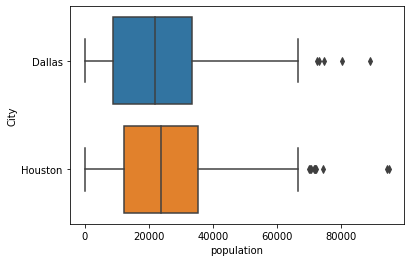

In [149]:
sns.boxplot(x = 'population', y ='City', data = merged_df)


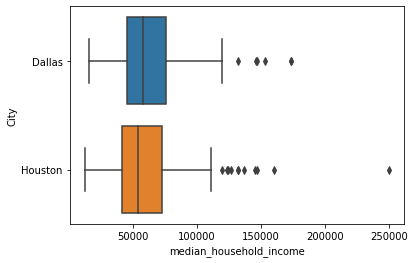

In [150]:
sns.boxplot(x = 'median_household_income', y = 'City', data = merged_df)

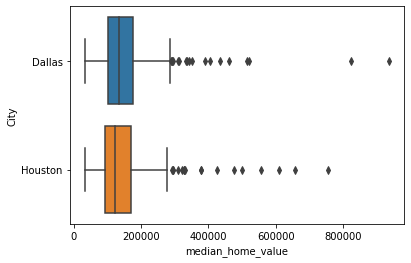

In [151]:
sns.boxplot(x = 'median_home_value', y = 'City', data = merged_df)

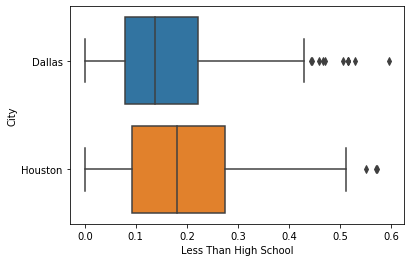

In [152]:
sns.boxplot(x = 'Less Than High School', y = 'City', data = merged_df)

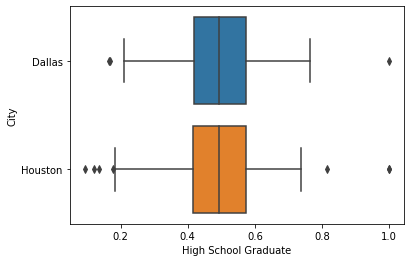

In [153]:
sns.boxplot(x = 'High School Graduate', y = 'City', data = merged_df)

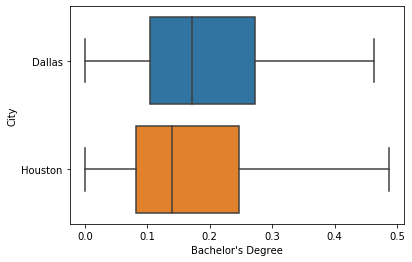

In [154]:
sns.boxplot(x = "Bachelor's Degree", y = 'City', data = merged_df)

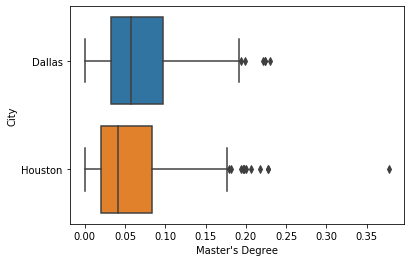

In [155]:
sns.boxplot(x = "Master's Degree", y = 'City', data = merged_df)

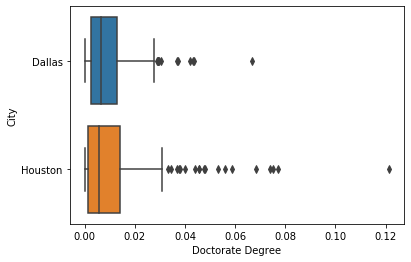

In [156]:
sns.boxplot(x = "Doctorate Degree", y = 'City', data = merged_df)

<a id='foursquare'></a>
### Foursquare Data
-----------

Now we will use the **Foursquare API** to get the types of shops that are in each zip code.


In [157]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import os and dotenv in order to load environmental variables for Foursquare credentials
import os
from dotenv import load_dotenv

import requests
              
import json
from pandas.io.json import json_normalize


Grab our Foursquare credentials

In [158]:
load_dotenv()
client_id = os.getenv('foursquare_id')
client_secret = os.getenv('foursquare_secret')
version = '20200508'

In [159]:
# Load our Dallas dataframe
dallas_df = pd.read_csv('./Data/dfw_demographics.csv')

In [160]:
dallas_df.head()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
0,75001,Addison,32.96,-96.84,12414,57633.0,258200.0,0.092103,0.366306,0.038184,0.332532,0.144217,0.023251,0.003407
1,75002,West Allen,33.08,-96.61,63140,91632.0,186100.0,0.052425,0.416282,0.085043,0.310966,0.109292,0.015340,0.010652
2,75006,Central Carrolton,32.95,-96.89,46364,56985.0,146800.0,0.252946,0.383821,0.066069,0.209083,0.075295,0.010197,0.002590
3,75007,North Carrollton,33.00,-96.90,51624,78934.0,169400.0,0.101158,0.426112,0.081565,0.288381,0.075876,0.014833,0.012075
4,75009,Celina,33.30,-96.80,8785,87581.0,190500.0,0.073749,0.525198,0.106760,0.215979,0.069008,0.006146,0.003161


In [161]:
dallas_df.tail()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
265,76487,Poolville,33.000,-97.90,2507,54872.0,132800.0,0.151007,0.605369,0.070470,0.141611,0.031544,0.000000,0.0
266,76490,Whitt,32.957,-98.02,91,107344.0,32500.0,0.172840,0.753086,0.074074,0.000000,0.000000,0.000000,0.0
267,76623,Avalon,32.300,-96.80,242,41250.0,80700.0,0.410526,0.536842,0.000000,0.052632,0.000000,0.000000,0.0
268,76651,Italy,32.200,-96.90,3300,50457.0,90300.0,0.224719,0.588764,0.048989,0.106067,0.029663,0.001798,0.0
269,76670,Milford,32.100,-97.00,1377,49667.0,86700.0,0.192175,0.660529,0.036824,0.100115,0.005754,0.004603,0.0


Create function that retrieve shops that are located in each zip code

In [162]:
def get_nearby_venues(names, latitudes, longitudes, radius= 16100, section = 'shops', limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius,
            section,
            limit)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        except:
            print(f'{name} has no restuarants')
    # Create dataframe for our shops data
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues  

In [163]:
# Capture our Foursquare data for Dallas
dallas_venues = get_nearby_venues(names = dallas_df['Neighborhood'],
                                   latitudes = dallas_df['lat'],
                                   longitudes = dallas_df['lng']
                                  )

Joshua has no restuarants
Kennedale has no restuarants
Lillian has no restuarants
Maypearl has no restuarants
Meadowbrook - Fort Worth has no restuarants


As you can see below, we have a dataframe of shops for each zip code below.  

In [164]:
dallas_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addison,32.96,-96.84,Whole Foods Market,32.953183,-96.821189,Grocery Store
1,Addison,32.96,-96.84,Trader Joe's,32.950679,-96.801981,Grocery Store
2,Addison,32.96,-96.84,Spec's,32.953851,-96.830795,Liquor Store
3,Addison,32.96,-96.84,Galleria Dallas,32.930022,-96.819643,Shopping Mall
4,Addison,32.96,-96.84,QuikTrip,32.933408,-96.802600,Convenience Store


In [165]:
dallas_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
25002,Milford,32.1,-97.0,T. B. Bond Pharmacy,32.010567,-97.130383,Pharmacy
25003,Milford,32.1,-97.0,steel stylin,32.009147,-97.130423,Health & Beauty Service
25004,Milford,32.1,-97.0,Redbox,32.007415,-97.130185,Video Store
25005,Milford,32.1,-97.0,7-Eleven,32.008289,-97.093517,Convenience Store
25006,Milford,32.1,-97.0,Outlets at Hillsboro,32.013207,-97.094421,Shopping Mall


In [166]:
# Save our data in order to stay within call limits for Foursquare API
dallas_venues.to_csv('./Data/dallas_venues.csv', index = False)

In [167]:
# Read in our Houston demographics dataframe
houston_df = pd.read_csv('./Data/houston_demographics.csv')

In [168]:
houston_df.head()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
0,77002,"Downtown, Midtown",29.75,-95.37,16793,64093.0,208600.0,0.265749,0.416079,0.049119,0.152974,0.071696,0.021696,0.022687
1,77003,East Downtown,29.75,-95.35,10508,36412.0,162600.0,0.318136,0.369392,0.038623,0.165674,0.061130,0.029331,0.017715
2,77004,"South Central, Greater Third Ward",29.72,-95.38,32692,41983.0,191700.0,0.157673,0.345377,0.040444,0.230725,0.137109,0.060271,0.028400
3,77005,West University Place,29.72,-95.42,25528,159732.0,754000.0,0.016033,0.122208,0.040450,0.334924,0.227403,0.184077,0.074904
4,77006,"Montrose, Hyde Park",29.74,-95.39,19664,67458.0,327300.0,0.033678,0.264526,0.030957,0.339017,0.172018,0.101215,0.058589


In [169]:
houston_df.tail()

,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
229,77665,Winnie,29.80,-94.30,6446,50149.0,116400.0,0.249186,0.575733,0.035831,0.100434,0.030130,0.005157,0.003529
230,78931,Bleiblerville,30.03,-96.44,323,67917.0,116400.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
231,78933,Cat Spring,29.80,-96.40,1433,59974.0,225700.0,0.049579,0.610851,0.037418,0.211413,0.061740,0.020580,0.008419
232,78944,Industry,30.00,-96.50,562,47083.0,154900.0,0.230461,0.561122,0.068136,0.036072,0.102204,0.002004,0.000000
233,78950,New Ulm,29.90,-96.50,2038,49261.0,170900.0,0.086690,0.559408,0.134115,0.150943,0.056604,0.012239,0.000000


In [170]:
# Get shops located in Houston zip codes
houston_venues = get_nearby_venues(names = houston_df['Neighborhood'],
                                   latitudes = houston_df['lat'],
                                   longitudes = houston_df['lng']
                                  )

East Tomball has no restuarants


In [171]:
houston_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, Midtown",29.75,-95.37,"Spec's Wines, Spirits & Finer Foods",29.748694,-95.376949,Liquor Store
1,"Downtown, Midtown",29.75,-95.37,Phoenicia Specialty Foods,29.754502,-95.361760,Supermarket
2,"Downtown, Midtown",29.75,-95.37,"Spec's Wines, Spirits & Finer Foods",29.744248,-95.392225,Liquor Store
3,"Downtown, Midtown",29.75,-95.37,Whole Foods Market,29.757994,-95.397643,Grocery Store
4,"Downtown, Midtown",29.75,-95.37,H-E-B,29.737913,-95.402618,Grocery Store


In [172]:
houston_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
21038,New Ulm,29.9,-96.5,Professional Processor,29.892169,-96.490388,Business Service
21039,New Ulm,29.9,-96.5,Family Dollar,29.971891,-96.500930,Discount Store
21040,New Ulm,29.9,-96.5,Nevins LLC,29.854891,-96.375605,Furniture / Home Store
21041,New Ulm,29.9,-96.5,Zebras For Sale,29.957574,-96.617578,Pet Store
21042,New Ulm,29.9,-96.5,Gagne's Landscaping,29.875202,-96.359582,Construction & Landscaping


In [173]:
# Save our data
houston_venues.to_csv('./Data/houston_venues.csv', index = False)

In [174]:
# Load our Dallas shop data
dallas_venues = pd.read_csv('./Data/dallas_venues.csv')

In [175]:
dallas_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addison,32.96,-96.84,Whole Foods Market,32.953183,-96.821189,Grocery Store
1,Addison,32.96,-96.84,Trader Joe's,32.950679,-96.801981,Grocery Store
2,Addison,32.96,-96.84,Spec's,32.953851,-96.830795,Liquor Store
3,Addison,32.96,-96.84,Galleria Dallas,32.930022,-96.819643,Shopping Mall
4,Addison,32.96,-96.84,QuikTrip,32.933408,-96.802600,Convenience Store


We are only going to use the zip codes that have 10 or more types of shops

In [176]:
# Filter dataframe by unique Venue Categories and show list of zip codes with less than 10
ten_or_less_unique_venues = dallas_venues[['Neighborhood','Venue Category']].groupby('Neighborhood').nunique() < 10
ten_or_less_unique_venues = ten_or_less_unique_venues[ten_or_less_unique_venues['Venue Category'] == True]
ten_or_less_unique_venues

,Neighborhood,Venue Category
Neighborhood,,
Lipan,True,True
Poolville,True,True
Rosser,True,True
Whitt,True,True


In [177]:
# Drop zip codes from venue and demographics dataframes with less than 10 unique venue categories
neighborhoods_to_drop = list(ten_or_less_unique_venues.index.values)
dallas_venues = dallas_venues[~dallas_venues['Neighborhood'].isin(neighborhoods_to_drop)]
dallas_df = dallas_df[~dallas_df['Neighborhood'].isin(neighborhoods_to_drop)] 

In [178]:
# Show number of unique categories
print('There are {} uniques categories.'.format(len(dallas_venues['Venue Category'].unique())))

There are 115 uniques categories.


We need to one hot encode the category names to use them for training our model

In [179]:
dallas_onehot = pd.get_dummies(dallas_venues[['Venue Category']], prefix="", prefix_sep="")
dallas_onehot['Neighborhood'] = dallas_venues['Neighborhood'] 
fixed_columns = [dallas_onehot.columns[-1]] + list(dallas_onehot.columns[:-1])
dallas_onehot = dallas_onehot[fixed_columns]
dallas_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Drugstore,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Frame Store,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Mobility Store,Motorcycle Shop,Motorsports Shop,Music Store,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pop-Up Shop,Print Shop,Public Bathroom,Rental Service,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now let's convert these to percentages 

In [180]:
dallas_grouped = dallas_onehot.groupby('Neighborhood').mean().reset_index()
dallas_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Drugstore,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Frame Store,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Mobility Store,Motorcycle Shop,Motorsports Shop,Music Store,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pop-Up Shop,Print Shop,Public Bathroom,Rental Service,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,"(Almeta, Bonite, Bella Vista) - Garland",0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.09,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.09,0.0,0.0,0.00,0.00,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.00,0.01,0.31,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.03,0.09,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.04,0.02,0.01,0.00,0.01,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.05,0.02,0.0
1,"(Arlington Heights, Monticello, West Beyer) - ...",0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.23,0.0,0.0,0.02,0.04,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.03,0.02,0.01,0.01,0.17,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.03,0.13,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.01,0.02,0.00,0.01,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.03,0.01,0.0
2,"(Bluffview, Greenway Parks) - Dallas",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.13,0.0,0.0,0.01,0.00,0.0,0.0,0.02,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.00,0.03,0.25,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.02,0.09,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.03,0.02,0.01,0.00,0.00,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.04,0.03,0.0
3,"(Casa Linda, Lockwood) - Dallas",0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.07,0.0,0.0,0.01,0.00,0.0,0.0,0.02,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.02,0.00,0.03,0.28,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.03,0.09,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.05,0.02,0.01,0.00,0.02,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.05,0.02,0.0
4,"(Casa View, Eastwood Hills) - Dallas",0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.01,

Next we will found the top 10 types of shops in each zip code

In [181]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [182]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

dallas_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
dallas_neighborhoods_venues_sorted['Neighborhood'] = dallas_grouped['Neighborhood']

for ind in np.arange(dallas_grouped.shape[0]):
    dallas_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dallas_grouped.iloc[ind, :], num_top_venues)

dallas_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"(Almeta, Bonite, Bella Vista) - Garland",Grocery Store,Supermarket,Convenience Store,Pharmacy,Big Box Store,Warehouse Store,Shopping Mall,Pet Store,Electronics Store,Wine Shop
1,"(Arlington Heights, Monticello, West Beyer) - ...",Convenience Store,Grocery Store,Pharmacy,Big Box Store,Discount Store,Supermarket,Liquor Store,Warehouse Store,Furniture / Home Store,Shipping Store
2,"(Bluffview, Greenway Parks) - Dallas",Grocery Store,Supermarket,Convenience Store,Pharmacy,Big Box Store,Warehouse Store,Liquor Store,Gourmet Shop,Wine Shop,Shopping Mall
3,"(Casa Linda, Lockwood) - Dallas",Grocery Store,Supermarket,Pharmacy,Convenience Store,Warehouse Store,Big Box Store,Shopping Mall,Gourmet Shop,Pet Store,Shopping Plaza
4,"(Casa View, Eastwood Hills) - Dallas",Grocery Store,Supermarket,Pharmacy,Convenience Store,Big Box Store,Warehouse Store,Shopping Mall,Gourmet Shop,Pet Store,Shopping Plaza


In [183]:
# Save top 10 venues per zip code for later use
dallas_neighborhoods_venues_sorted.to_csv('./Data/dallas_top_10_venues.csv', index = False)

As expected grocery stores, supermarkets, and convenience stores are very common.

In [184]:
# Concatenate our demographics df with our venue categories df
dallas_combined_df = pd.concat([dallas_df.set_index('Neighborhood'), dallas_grouped.set_index('Neighborhood')], axis = 1, sort = False)

In [185]:
dallas_combined_df.head()

,Zip_Code,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree,ATM,Accessories Store,Adult Boutique,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Drugstore,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Frame Store,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Mobility Store,Motorcycle Shop,Motorsports Shop,Music Store,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pop-Up Shop,Print Shop,Public Bathroom,Rental Service,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
Addison,75001,32.96,-96.84,12414,57633.0,258200.0,0.092103,0.366306,0.038184,0.332532,0.144217,0.023251,0.003407,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.10,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.05,0.01,0.0,0.00,0.01,0.0,0.0,0.02,0.0,0.02,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.02,0.26,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.05,0.01,0.0,0.00,0.01,0.16,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.07,0.06,0.0
West Allen,75002,33.08,-96.61,63140,91632.0,186100.0,0.052425,0.416282,0.085043,0.310966,0.109292,0.015340,0.010652,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.07,0.00,0.0,0.01,0.02,0.0,0.0,0.02,0.0,0.02,0.02,0.0,0.0,0.00,0.0,0.0,0.01,0.00,0.0,0.0,0.01,0.02,0.0,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.02,0.13,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.02,0.02,0.0,0.01,0.02,0.16,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.04,0.02,0.0
Central Carrolton,75006,32.95,-96.89,46364,56985.0,146800.0,0.252946,0.383821,0.066069,0.209083,0.075295,0.010197,0.002590,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.09,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.09,0.01,0.0,0.02,0.01,0.0,0.0,0.02,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.02,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.04,0.01,0.0,0.00,0.02,0.15,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.06,0.04,0.0
North Carrollton,75007,33.00,-96.90,51624,78934.0,169400.0,0.101158,0.426112,0.081565,0.288381,0.075876,0.014833,0.012075,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.05,0.01,0.0,0.02,0.01,0.0,0.0,0.01,0.0,0.

In [186]:
# Reset index
dallas_combined_df = dallas_combined_df.reset_index()

In [187]:
dallas_combined_df.head()

,index,Zip_Code,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree,ATM,Accessories Store,Adult Boutique,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Drugstore,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Frame Store,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Mobility Store,Motorcycle Shop,Motorsports Shop,Music Store,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pop-Up Shop,Print Shop,Public Bathroom,Rental Service,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,Addison,75001,32.96,-96.84,12414,57633.0,258200.0,0.092103,0.366306,0.038184,0.332532,0.144217,0.023251,0.003407,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.10,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.05,0.01,0.0,0.00,0.01,0.0,0.0,0.02,0.0,0.02,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.02,0.26,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.05,0.01,0.0,0.00,0.01,0.16,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.07,0.06,0.0
1,West Allen,75002,33.08,-96.61,63140,91632.0,186100.0,0.052425,0.416282,0.085043,0.310966,0.109292,0.015340,0.010652,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.07,0.00,0.0,0.01,0.02,0.0,0.0,0.02,0.0,0.02,0.02,0.0,0.0,0.00,0.0,0.0,0.01,0.00,0.0,0.0,0.01,0.02,0.0,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.02,0.13,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.02,0.02,0.0,0.01,0.02,0.16,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.04,0.02,0.0
2,Central Carrolton,75006,32.95,-96.89,46364,56985.0,146800.0,0.252946,0.383821,0.066069,0.209083,0.075295,0.010197,0.002590,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.09,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.09,0.01,0.0,0.02,0.01,0.0,0.0,0.02,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.02,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.04,0.01,0.0,0.00,0.02,0.15,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.06,0.04,0.0
3,North Carrollton,75007,33.00,-96.90,51624,78934.0,169400.0,0.101158,0.426112,0.081565,0.288381,0.075876,0.014833,0.012075,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.05,0.01,0.0,0.02,0.01,0.0,0

In [188]:
# Rename column
dallas_combined_df = dallas_combined_df.rename(columns = {'index': 'Neighborhood'})

In [189]:
dallas_combined_df.head()

,Neighborhood,Zip_Code,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree,ATM,Accessories Store,Adult Boutique,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Drugstore,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Frame Store,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Mobility Store,Motorcycle Shop,Motorsports Shop,Music Store,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pop-Up Shop,Print Shop,Public Bathroom,Rental Service,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,Addison,75001,32.96,-96.84,12414,57633.0,258200.0,0.092103,0.366306,0.038184,0.332532,0.144217,0.023251,0.003407,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.10,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.05,0.01,0.0,0.00,0.01,0.0,0.0,0.02,0.0,0.02,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.02,0.26,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.05,0.01,0.0,0.00,0.01,0.16,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.07,0.06,0.0
1,West Allen,75002,33.08,-96.61,63140,91632.0,186100.0,0.052425,0.416282,0.085043,0.310966,0.109292,0.015340,0.010652,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.07,0.00,0.0,0.01,0.02,0.0,0.0,0.02,0.0,0.02,0.02,0.0,0.0,0.00,0.0,0.0,0.01,0.00,0.0,0.0,0.01,0.02,0.0,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.02,0.13,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.02,0.02,0.0,0.01,0.02,0.16,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.04,0.02,0.0
2,Central Carrolton,75006,32.95,-96.89,46364,56985.0,146800.0,0.252946,0.383821,0.066069,0.209083,0.075295,0.010197,0.002590,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.09,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.09,0.01,0.0,0.02,0.01,0.0,0.0,0.02,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.02,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.04,0.01,0.0,0.00,0.02,0.15,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.06,0.04,0.0
3,North Carrollton,75007,33.00,-96.90,51624,78934.0,169400.0,0.101158,0.426112,0.081565,0.288381,0.075876,0.014833,0.012075,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.05,0.01,0.0,0.02,0.0

In [190]:
# Save our dataframe
dallas_combined_df.to_csv('./Data/dallas_combined_df.csv', index = False)

Now we need to do the same process for the Houston data

In [191]:
# Read Houston venues data
houston_venues = pd.read_csv('./Data/houston_venues.csv')

In [192]:
houston_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, Midtown",29.75,-95.37,"Spec's Wines, Spirits & Finer Foods",29.748694,-95.376949,Liquor Store
1,"Downtown, Midtown",29.75,-95.37,Phoenicia Specialty Foods,29.754502,-95.361760,Supermarket
2,"Downtown, Midtown",29.75,-95.37,"Spec's Wines, Spirits & Finer Foods",29.744248,-95.392225,Liquor Store
3,"Downtown, Midtown",29.75,-95.37,Whole Foods Market,29.757994,-95.397643,Grocery Store
4,"Downtown, Midtown",29.75,-95.37,H-E-B,29.737913,-95.402618,Grocery Store


In [193]:
# Find zip codes with less than 10 unique venue categories
ten_or_less_unique_venues = houston_venues[['Neighborhood','Venue Category']].groupby('Neighborhood').nunique() < 10
ten_or_less_unique_venues = ten_or_less_unique_venues[ten_or_less_unique_venues['Venue Category'] == True]
ten_or_less_unique_venues

,Neighborhood,Venue Category
Neighborhood,,
Cat Spring,True,True
Central Bolivar Peninsula,True,True
Damon,True,True
Devers,True,True
East Bolivar Peninsula,True,True
East Cleveland,True,True
Industry,True,True
New Ulm,True,True
Romayor,True,True


In [194]:
# Drop zip codes with less than 10 unique venue categories
neighborhoods_to_drop = list(ten_or_less_unique_venues.index.values)
houston_venues = houston_venues[~houston_venues['Neighborhood'].isin(neighborhoods_to_drop)]
houston_df = houston_df[~houston_df['Neighborhood'].isin(neighborhoods_to_drop)] 


In [195]:
# Show number of unique venue categories
print('There are {} uniques categories.'.format(len(houston_venues['Venue Category'].unique())))

There are 116 uniques categories.


One hot encode venue categories 

In [196]:
houston_onehot = pd.get_dummies(houston_venues[['Venue Category']], prefix="", prefix_sep="")
houston_onehot['Neighborhood'] = houston_venues['Neighborhood'] 
fixed_columns = [houston_onehot.columns[-1]] + list(houston_onehot.columns[:-1])
houston_onehot = houston_onehot[fixed_columns]
houston_onehot.head()

,Neighborhood,ATM,Accessories Store,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Dry Cleaner,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fish Market,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Leather Goods Store,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Music Store,Notary,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Print Shop,Public Bathroom,Record Shop,Recording Studio,Rental Service,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Stationery Store,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,"Downtown, Midtown",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Downtown, Midtown",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Downtown, Midtown",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Downtown, Midtown",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Downtown, Midtown",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [197]:
# Convert to percentages
houston_grouped = houston_onehot.groupby('Neighborhood').mean().reset_index()
houston_grouped.head()

,Neighborhood,ATM,Accessories Store,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Dry Cleaner,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fish Market,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Leather Goods Store,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Music Store,Notary,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Print Shop,Public Bathroom,Record Shop,Recording Studio,Rental Service,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Stationery Store,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,North Humble,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00,0.03,0.0,0.01,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.01,0.05,0.02,0.0,0.03,0.14,0.0,0.03,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.02,0.00,0.03,0.01,0.0,0.00,0.07,0.01,0.00,0.0,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.0,0.0,0.00,0.00,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.01,0.00,0.0,0.06,0.16,0.0,0.00,0.0,0.0,0.0,0.0,0.06,0.01,0.0,0.00,0.0,0.00,0.02,0.04,0.0,0.05,0.01,0.0,0.00,0.0,0.0,0.01,0.00,0.02,0.01,0.0
1,"Addicks, Park Ten",0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.00,0.06,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.05,0.00,0.0,0.02,0.03,0.0,0.01,0.0,0.00,0.03,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.01,0.03,0.00,0.00,0.00,0.0,0.01,0.24,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.07,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.02,0.09,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.05,0.0,0.00,0.01,0.05,0.0,0.13,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.05,0.02,0.0
2,Aldine,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.09,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.02,0.00,0.0,0.03,0.06,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.00,0.00,0.00,0.01,0.00,0.0,0.00,0.12,0.00,0.01,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.02,0.00,0.0,0.01,0.0,0.0,0.00,0.01,0.01,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.03,0.00,0.0,0.04,0.22,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.01,0.0,0.01,0.02,0.02,0.0,0.11,0.00,0.0,0.00,0.0,0.0,0.00,0.01,0.02,0.00,0.0
3,Alief,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.00,0.08,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.01,0.00,0.02,0.00,0.0,0.02,0.00,0.0,0.01,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.01,0.01,0.01,0.01,0.00,0.0,0.02,0.25,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.06,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.09,0.0,0.01,0.01,0.03,0.0,0.17,0.01,0.0,0.00,0.0,0.0,0.00,0.00,0.06,0.02,0.0
4,Alvin,0.0,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.00,0.01,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.01,0.01,0.0,0.0,0.00,0.03,0.00,0.09,0.05,0.02,0.0,0

In [198]:
# Get our top 10 venues for each zip code
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

houston_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
houston_neighborhoods_venues_sorted['Neighborhood'] = houston_grouped['Neighborhood']

for ind in np.arange(houston_grouped.shape[0]):
    houston_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(houston_grouped.iloc[ind, :], num_top_venues)

houston_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Humble,Pharmacy,Discount Store,Grocery Store,Shipping Store,Pet Store,Supermarket,Convenience Store,Sporting Goods Shop,Big Box Store,Electronics Store
1,"Addicks, Park Ten",Grocery Store,Supermarket,Pharmacy,Liquor Store,Big Box Store,Shopping Mall,Warehouse Store,Convenience Store,Sporting Goods Shop,Discount Store
2,Aldine,Pharmacy,Grocery Store,Supermarket,Big Box Store,Discount Store,Shipping Store,Pet Store,Paper / Office Supplies Store,Department Store,Liquor Store
3,Alief,Grocery Store,Supermarket,Shopping Mall,Big Box Store,Warehouse Store,Liquor Store,Pharmacy,Sporting Goods Shop,Department Store,Wine Shop
4,Alvin,Home Service,Construction & Landscaping,Mobile Phone Shop,Grocery Store,Discount Store,Business Service,Video Store,Convenience Store,Furniture / Home Store,Insurance Office


In [199]:
# Save for later use
houston_neighborhoods_venues_sorted.to_csv('./Data/houston_top_10_venues.csv', index = False)

In [200]:
# Concatenate our demographics df with our venues df
houston_combined_df = pd.concat([houston_df.set_index('Neighborhood'), houston_grouped.set_index('Neighborhood')], axis = 1, sort = False)

In [201]:
houston_combined_df.head()

,Zip_Code,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree,ATM,Accessories Store,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Dry Cleaner,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fish Market,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Leather Goods Store,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Music Store,Notary,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Print Shop,Public Bathroom,Record Shop,Recording Studio,Rental Service,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Stationery Store,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
"Downtown, Midtown",77002,29.75,-95.37,16793,64093.0,208600.0,0.265749,0.416079,0.049119,0.152974,0.071696,0.021696,0.022687,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.0,0.02,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.01,0.00,0.0,0.01,0.21,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.04,0.0,0.01,0.02,0.02,0.0,0.12,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.02,0.0
East Downtown,77003,29.75,-95.35,10508,36412.0,162600.0,0.318136,0.369392,0.038623,0.165674,0.061130,0.029331,0.017715,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.00,0.0,0.0,0.02,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.01,0.01,0.0,0.01,0.22,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.05,0.0,0.01,0.02,0.03,0.0,0.11,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0
"South Central, Greater Third Ward",77004,29.72,-95.38,32692,41983.0,191700.0,0.157673,0.345377,0.040444,0.230725,0.137109,0.060271,0.028400,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.0,0.03,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.01,0.00,0.0,0.01,0.20,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.04,0.0,0.01,0.02,0.01,0.0,0.13,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0
West University Place,77005,29.72,-95.42,25528,159732.0,754000.0,0.016033,0.122208,0.040450,0.334924,0.227403,0.184077,0.074904,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,

In [202]:
# Reset index
houston_combined_df = houston_combined_df.reset_index()

In [203]:
houston_combined_df.head()

,index,Zip_Code,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree,ATM,Accessories Store,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Dry Cleaner,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fish Market,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Leather Goods Store,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Music Store,Notary,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Print Shop,Public Bathroom,Record Shop,Recording Studio,Rental Service,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Stationery Store,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,"Downtown, Midtown",77002,29.75,-95.37,16793,64093.0,208600.0,0.265749,0.416079,0.049119,0.152974,0.071696,0.021696,0.022687,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.0,0.02,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.01,0.00,0.0,0.01,0.21,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.04,0.0,0.01,0.02,0.02,0.0,0.12,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.02,0.0
1,East Downtown,77003,29.75,-95.35,10508,36412.0,162600.0,0.318136,0.369392,0.038623,0.165674,0.061130,0.029331,0.017715,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.00,0.0,0.0,0.02,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.01,0.01,0.0,0.01,0.22,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.05,0.0,0.01,0.02,0.03,0.0,0.11,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0
2,"South Central, Greater Third Ward",77004,29.72,-95.38,32692,41983.0,191700.0,0.157673,0.345377,0.040444,0.230725,0.137109,0.060271,0.028400,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.0,0.03,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.01,0.00,0.0,0.01,0.20,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.04,0.0,0.01,0.02,0.01,0.0,0.13,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0
3,West University Place,77005,29.72,-95.42,25528,159732.0,754000.0,0.016033,0.122208,0.040450,0.334924,0.227403,0.184077,0.074904,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [204]:
# Rename column 
houston_combined_df = houston_combined_df.rename(columns = {'index': 'Neighborhood'})

In [205]:
houston_combined_df.head()

,Neighborhood,Zip_Code,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree,ATM,Accessories Store,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Beer Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Dry Cleaner,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Fireworks Store,Fish Market,Fishing Store,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Service,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hunting Supply,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Laundromat,Lawyer,Leather Goods Store,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Music Store,Notary,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Print Shop,Public Bathroom,Record Shop,Recording Studio,Rental Service,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Stationery Store,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Vape Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,"Downtown, Midtown",77002,29.75,-95.37,16793,64093.0,208600.0,0.265749,0.416079,0.049119,0.152974,0.071696,0.021696,0.022687,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.0,0.02,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.01,0.00,0.0,0.01,0.21,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.04,0.0,0.01,0.02,0.02,0.0,0.12,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.02,0.0
1,East Downtown,77003,29.75,-95.35,10508,36412.0,162600.0,0.318136,0.369392,0.038623,0.165674,0.061130,0.029331,0.017715,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.00,0.0,0.0,0.02,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.01,0.01,0.0,0.01,0.22,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.05,0.0,0.01,0.02,0.03,0.0,0.11,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0
2,"South Central, Greater Third Ward",77004,29.72,-95.38,32692,41983.0,191700.0,0.157673,0.345377,0.040444,0.230725,0.137109,0.060271,0.028400,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.0,0.03,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.01,0.00,0.0,0.01,0.20,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.04,0.0,0.01,0.02,0.01,0.0,0.13,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0
3,West University Place,77005,29.72,-95.42,25528,159732.0,754000.0,0.016033,0.122208,0.040450,0.334924,0.227403,0.184077,0.074904,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [206]:
# Save our dataframe
houston_combined_df.to_csv('./Data/houston_combined_df.csv', index = False)

<a id='kmeans'></a>
### KMeans Clustering Model
-------------

In this section, we will build the model that will be used in our app. Below we have created a function that will take a user inputted zip code and return similar neighborhoods in the other Metroplex.  The data will be scaled using the StandardScaler and then the model will be trained.  The model will return a dataframe of the similar neighborhoods.


In [207]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [208]:
def find_similar_neighorhoods(zip_code, dallas_df, houston_df):
    # Check to see what Metroplex the user inputted zip code is located
    if zip_code in houston_df['Zip_Code'].values:
        # Pull the zip codes' features
        zip_code_data = houston_df[houston_df['Zip_Code'] == zip_code]
        # Append to other Metroplex dataframe
        combined_df = dallas_df.append(zip_code_data, sort = False).reset_index(drop = True)
        combined_df = combined_df.replace(np.nan, 0)
        # Drop data not used for training
        training_df = combined_df.drop(columns = ['Neighborhood', 'Zip_Code','lat', 'lng'])
        # Scale data
        scaler = StandardScaler()
        training_data_scaled = scaler.fit_transform(training_df)
        kmeans = KMeans(n_clusters = 20, random_state = 0)
        kmeans.fit(training_data_scaled)
        # Put cluster labels into dataframe
        combined_df.insert(0, 'Cluster Labels', kmeans.labels_)
        # Find cluster where user inputted zip code is located
        neighborhood_cluster = combined_df[combined_df['Cluster Labels'] == combined_df.iloc[-1]['Cluster Labels']]
        return neighborhood_cluster
    elif zip_code in dallas_df['Zip_Code'].values:
        # Pull the zip codes' feature
        zip_code_data = dallas_df[dallas_df['Zip_Code'] == zip_code]
        # Append to other Metroplex dataframe
        combined_df = houston_df.append(zip_code_data, sort = False).reset_index(drop = True)
        combined_df = combined_df.replace(np.nan, 0)
        # Drop data not used for training
        training_df = combined_df.drop(columns = ['Neighborhood', 'Zip_Code','lat', 'lng'])
        # Scale data
        scaler = StandardScaler()
        training_data_scaled = scaler.fit_transform(training_df)
        kmeans = KMeans(n_clusters = 20, random_state = 0)
        kmeans.fit(training_data_scaled)
        # Put cluster labels into dataframe
        combined_df.insert(0, 'Cluster Labels', kmeans.labels_)
        # Find cluster where user inputted zip code is located
        neighborhood_cluster = combined_df[combined_df['Cluster Labels'] == combined_df.iloc[-1]['Cluster Labels']]
        return neighborhood_cluster
    else:
        print('Not there')

Now we will find areas in Dallas similiar to Alvin, TX (Greater Houston Area).

In [209]:
alvin = 77598
alvin_similiar_neighborhoods = find_similar_neighorhoods(77511,dallas_df,houston_df)

Here's Dallas Metroplex areas similar to Alvin, TX

In [210]:
alvin_similiar_neighborhoods

,Cluster Labels,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
2,6,75006,Central Carrolton,32.95,-96.89,46364,56985.0,146800.0,0.252946,0.383821,0.066069,0.209083,0.075295,0.010197,0.002590
18,6,75040,Northeast Garland,32.93,-96.62,59406,54664.0,113000.0,0.277941,0.457556,0.074419,0.143659,0.037182,0.005752,0.003489
21,6,75043,Bass Park Area - Garland,32.86,-96.59,58094,55149.0,120900.0,0.158050,0.534518,0.083426,0.159140,0.051102,0.008940,0.004824
24,6,75050,North Grand Prairie,32.78,-96.99,41041,44548.0,104400.0,0.223820,0.540133,0.058738,0.131408,0.036965,0.003575,0.005362
26,6,75052,Southwest Grand Prairie,32.65,-97.02,88996,66744.0,134300.0,0.146012,0.495276,0.080888,0.199825,0.062329,0.009727,0.005944
32,6,75062,"(Hillcrest Oaks, Arts District, Woodhaven) - I...",32.85,-96.96,44537,45872.0,121600.0,0.213197,0.459506,0.062052,0.186707,0.058602,0.011969,0.007968
35,6,75067,West to Southwest Lewisville,33.02,-96.99,60982,56555.0,149100.0,0.124049,0.479388,0.082725,0.225022,0.071958,0.007355,0.009503
37,6,75069,Southeast McKinney,33.18,-96.59,34108,45907.0,176400.0,0.185590,0.466385,0.055040,0.221707,0.055222,0.009234,0.006823
40,6,75074,"(Timber Brook, Oak Point, Plano Park) - Plano",33.04,-96.67,44622,54518.0,145400.0,0.194117,0.430938,0.065664,0.214911,0.072223,0.014032,0.008115
56,6,75115,DeSoto,32.61,-96.87,48877,61729.0,142300.0,0.081318,0.543611,0.090309,0.192425,0.075596,0.009930,0.006812


Find the geographic center of this cluster for later mapping purposes

In [211]:
# Drop Alvin from df
cluster_df = alvin_similiar_neighborhoods.iloc[:-1]
# Find cluster center
cluster_lat = cluster_df['lat'].sum() / len(cluster_df['lat'])
cluster_lng = cluster_df['lng'].sum() / len(cluster_df['lng'])
print(f'The cluster center is located at {cluster_lat}, {cluster_lng}')

The cluster center is located at 32.794347826086955, -96.9813043478261


In [212]:
# Save cluster for later visualization
alvin_similiar_neighborhoods.to_csv('./Data/sample.csv', index = False)

<a id='folium'></a>
### Folium Maps 
-------------------  

In this section, I will show the visualization that will be used in the app.  The maps are rendered by using the Folium library.  I am also using a specific Mapbox tile for the maps.  


In [213]:
import folium
from IPython.core.display import display, HTML


In [214]:
# Get our mapbox api key from the .env file
load_dotenv()
token = os.getenv('mapbox_key')

First let's map the Greater Houston and DFW areas side by side.  Currently folium doesn't support side by side maps of seperate locations but with a little help from a stackoverflow post, we are able to pull it off.


In [215]:
# Create houston map object
greater_houston = folium.Map(location=[29.754, -95.357], tiles ='https://api.mapbox.com/styles/v1/josh-miller/ckabacn800o2d1ipjlx88fksf/tiles/256/{z}/{x}/{y}@2x?' + f'access_token={token}',
                          zoom_start=10, attr = 'None')

In [216]:
# Create Dallas map object
dfw = folium.Map(location=[32.844, -97.010], tiles ='https://api.mapbox.com/styles/v1/josh-miller/ckabacn800o2d1ipjlx88fksf/tiles/256/{z}/{x}/{y}@2x?' + f'access_token={token}',
                          zoom_start=10, attr = 'None')

In [217]:
# A little HTML magic
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 1px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 49%; margin: 0 auto; border: 1px solid black"></iframe>'
           .format(greater_houston.get_root().render().replace('"', '&quot;'),500,600,
                   dfw.get_root().render().replace('"', '&quot;'),500,600))

C:\Users\willi\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [218]:
display(htmlmap)

Now we will visualize our neighborhood cluster that shows the areas similar to Alvin, TX (Greater Houston Area) located in the DFW Area

In [219]:
# Read in our sample zip code cluster for Alvin, TX
sample = pd.read_csv('./Data/sample.csv')

In [220]:
sample.head()

,Cluster Labels,Zip_Code,Neighborhood,lat,lng,population,median_household_income,median_home_value,Less Than High School,High School Graduate,Associate's Degree,Bachelor's Degree,Master's Degree,Professional Degree,Doctorate Degree
0,6,75006,Central Carrolton,32.95,-96.89,46364,56985.0,146800.0,0.252946,0.383821,0.066069,0.209083,0.075295,0.010197,0.002590
1,6,75040,Northeast Garland,32.93,-96.62,59406,54664.0,113000.0,0.277941,0.457556,0.074419,0.143659,0.037182,0.005752,0.003489
2,6,75043,Bass Park Area - Garland,32.86,-96.59,58094,55149.0,120900.0,0.158050,0.534518,0.083426,0.159140,0.051102,0.008940,0.004824
3,6,75050,North Grand Prairie,32.78,-96.99,41041,44548.0,104400.0,0.223820,0.540133,0.058738,0.131408,0.036965,0.003575,0.005362
4,6,75052,Southwest Grand Prairie,32.65,-97.02,88996,66744.0,134300.0,0.146012,0.495276,0.080888,0.199825,0.062329,0.009727,0.005944


In [221]:
# Set our map's center from the cluster center values in the previous section
latitude = cluster_lat
longitude = cluster_lng

In [222]:
# Create map object for our cluster
map_clusters = folium.Map(location=[latitude, longitude], tiles ='https://api.mapbox.com/styles/v1/josh-miller/ckabacn800o2d1ipjlx88fksf/tiles/256/{z}/{x}/{y}@2x?' + f'access_token={token}',
                          zoom_start=10, attr = 'None')


In [223]:
# Add circle markers for our neighborhood locations
for lat, lon, poi in zip(sample['lat'], sample['lng'], sample['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color = '#0c325b',
        fill = True,
        fill_opacity=0.9,
        popup=label).add_to(map_clusters)

In [224]:
# Show our map
map_clusters

<a id='streamlit'></a>
### Streamlit 
-----------

For the Streamlit app I took the functions that were made in this notebook and transferred the needed ones into the app.py file that will be run by the streamlit library.


This is the contents of the app.py file:

```
import streamlit as st
import pandas as pd
import folium
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load our data

@st.cache(persist = True, suppress_st_warning = True)
def load_data():
    dallas_df = pd.read_csv('./Data/dallas_combined_df.csv')
    houston_df = pd.read_csv('./Data/houston_combined_df.csv')
    dallas_top_10_venues = pd.read_csv('./Data/dallas_top_10_venues.csv')
    houston_top_10_venues = pd.read_csv('./Data/houston_top_10_venues.csv')
    return dallas_df, houston_df, dallas_top_10_venues, houston_top_10_venues

def find_similar_neighorhoods(zip_code, dallas_df, houston_df, dallas_top_10, houston_top_10):
    # Check to see what Metroplex the user inputted zip code is located
    if zip_code in houston_df['Zip_Code'].values:
        # Pull the zip codes' features
        zip_code_data = houston_df[houston_df['Zip_Code'] == zip_code]
        # Append to other Metroplex dataframe
        combined_df = dallas_df.append(zip_code_data, sort = False).reset_index(drop = True)
        combined_df = combined_df.replace(np.nan, 0)
        training_df = combined_df.drop(columns = ['Neighborhood', 'Zip_Code','lat', 'lng'])
        top_10_venues = dallas_top_10
    elif zip_code in dallas_df['Zip_Code'].values:
        # Pull the zip codes' feature
        zip_code_data = dallas_df[dallas_df['Zip_Code'] == zip_code]
        # Append to other Metroplex dataframe
        combined_df = houston_df.append(zip_code_data, sort = False).reset_index(drop = True)
        combined_df = combined_df.replace(np.nan, 0)
        # Drop data not used for training
        training_df = combined_df.drop(columns = ['Neighborhood', 'Zip_Code','lat', 'lng'])
        top_10_venues = houston_top_10
    else:
        return st.markdown('Please Enter A Valid Zip Code')
        
    # Scale data
    scaler = StandardScaler()
    training_data_scaled = scaler.fit_transform(training_df)
    kmeans = KMeans(n_clusters = 20, random_state = 0)
    kmeans.fit(training_data_scaled)
    # Put cluster labels into dataframe
    combined_df.insert(0, 'Cluster Labels', kmeans.labels_)
    # Find cluster where user inputted zip code is located
    neighborhood_cluster = combined_df[combined_df['Cluster Labels'] == combined_df.iloc[-1]['Cluster Labels']]
    neighborhood_cluster = neighborhood_cluster.drop(columns = 'Cluster Labels')
    neighborhood_cluster = neighborhood_cluster.loc[:,:'Doctorate Degree']
    neighborhood_df = pd.concat([neighborhood_cluster.set_index('Neighborhood'), top_10_venues.set_index('Neighborhood')], axis = 1, sort = False).dropna()
    neighborhood_df = neighborhood_df.drop(columns = ['lat', 'lng'])
    education_columns = ['Less Than High School', 'High School Graduate', "Associate's Degree", "Bachelor's Degree", "Master's Degree", 'Professional Degree', 'Doctorate Degree']
    for education in education_columns:
        neighborhood_df[education] = (neighborhood_df[education] * 100).round(2).astype(str) + '%'
    format_dict = {'median_home_value': '${0:,.0f}', 'median_household_income': '${0:,.0f}'}
    neighborhood_df = neighborhood_df.style.format(format_dict)
    return neighborhood_cluster, neighborhood_df


def cluster_map(neighborhood_cluster, token):
    # Drop user zip code from cluster
    cluster_df = neighborhood_cluster.iloc[:-1]
    if len(cluster_df) < 1:
        return st.markdown('No Similiar Neighborhoods')
    # Find latitude for cluster center
    cluster_lat = cluster_df['lat'].sum() / len(cluster_df['lat'])
    # Find Longitude for cluster center
    cluster_lng = cluster_df['lng'].sum() / len(cluster_df['lng'])
    # Create map object
    map_clusters = folium.Map(location=[cluster_lat, cluster_lng], tiles ='https://api.mapbox.com/styles/v1/josh-miller/ckabacn800o2d1ipjlx88fksf/tiles/256/{z}/{x}/{y}@2x?' + f'access_token={token}',
                          zoom_start=9, attr = 'None')
    # Add circle markers for our neighborhood locations
    for lat, lon, poi in zip(neighborhood_cluster['lat'], neighborhood_cluster['lng'], neighborhood_cluster['Neighborhood']):
        tooltip_label = folium.Tooltip(str(poi))
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            color = '#0c325b',
            fill = True,
            fill_opacity=0.9,
            tooltip=tooltip_label).add_to(map_clusters)
    return st.markdown(map_clusters._repr_html_(), unsafe_allow_html=True)





def main():
    dallas_df, houston_df, dallas_top_10, houston_top_10 = load_data()
    token = os.getenv('token')
    st.header('Similiar Areas of DFW and Houston')
    st.image('./Data/Houston-vs-Dallas-direct-flights-to-India.png')
    st.markdown('The current job market has substantially contracted in the last few months due to the economic decline caused by the novel coronavirus(COVID-19).  Many people have lost their jobs or were already looking to change jobs.  With the job prospects looking thinner by the day, job seekers will start considering relocation to expand their opportunities for employment. The transition of uprooting your family and moving to a new area can only add to the stress of changing jobs. The goal of this analysis is to help locate a neighborhood that is similar to the neighborhood that one is currently living in.  This analysis focuses on those transitioning between the Greater Houston and Greater Dallas markets.  The neighborhoods will be clustered using the *k-means* algorithm based on a variety of features of each neighborhood. The features used for clustering will include types of shops located near the neighborhood, population, median household income, education, and median home value.')
    zip_code = st.number_input('Input Your Zip Code', value = 77511)
    neighborhood_cluster, neighborhood_df = find_similar_neighorhoods(zip_code, dallas_df, houston_df, dallas_top_10, houston_top_10)
    cluster_map(neighborhood_cluster, token)
    st.dataframe(neighborhood_df)


if __name__ == "__main__":
    main()
    
```   

For information on how to build a streamlit app, check out their documentation at https://docs.streamlit.io/

<a id='heroku'></a>
### Heroku
-----------
Now that the streamlit app is built, it will be hosted on Heroku.  Please check out https://towardsdatascience.com/how-to-deploy-your-data-science-as-web-apps-easily-with-python-955dd462a9b5 for detailed instructions on how to host a streamlit app on Heroku.  Below I will share the files I created to host the app on Heroku.


**Below is the Procfile:**

```
web: sh setup.sh && streamlit run app.py
```

**Below is the setup.sh file:**

```
mkdir -p ~/.streamlit/
echo "\
[server]\n\
headless = true\n\
enableCORS=false\n\
port = $PORT\n\
" > ~/.streamlit/config.toml
```

**Below is the requirements.txt file:**

```
streamlit==0.59.0
pandas==0.25.3
folium==0.11.0
numpy==1.18.1
scikit-learn==0.22.1
branca==0.3.1
```

<a id='application'></a>
### Application
------------------

To see what the final app look likes go to https://dfw-houston-clustering.herokuapp.com/
